# What is the variation in $d^2m$ and $dt^2$ in our data?

In [1]:
base_directory = '/home/shoaib/ZTFDataChallenge/'

import sys
sys.path.insert(0, base_directory + 'dmdt_Analysis/')
from dmdt_functions import *

In [2]:
import numpy as np
from tqdm.auto import tqdm
tqdm.pandas(desc="Lightcurves Processed")

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)

import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')
# plt.style.use('seaborn-v0_8-colorblind')

In [3]:
qso_types = ['Q', 'QR', 'QX']

In [4]:
dmdt_curves_by_name = pd.read_pickle(base_directory + 'dmdt_curves_by_name.pkl').dropna(axis=0)
# dmdt_curves_by_name = dmdt_curves_by_name.query("type in @qso_types")
dmdt_curves_by_name = dmdt_curves_by_name.sample(frac=0.1)

dmdt_curves_by_oid = pd.read_pickle(base_directory + 'dmdt_curves_by_oid.pkl').dropna(axis=0)
# dmdt_curves_by_oid = dmdt_curves_by_oid.query("type in @qso_types")
dmdt_curves_by_oid = dmdt_curves_by_oid.sample(frac=0.1)

In [12]:
def large_histogram_one_band(df, quantity_index, lightcurve_key, bins, nchunks, **kwargs):
    hist = np.zeros(shape=(bins.size - 1, ))
    chunks = np.array_split(df, nchunks)
    for chunk in chunks:
        chunk_hist, _ = np.histogram(np.concat(chunk[lightcurve_key].apply(lambda lightcurve: return_dquantities(lightcurve[:, quantity_index])).to_numpy()), bins=bins, **kwargs)
        hist += chunk_hist
    return hist, bins


def return_d2mdt2_1Dhistograms(timeseries_array, d2m_bins, dt2_bins, nchunks=10):
    d2m_hist = np.zeros(shape=(d2m_bins.size - 1, ))
    dt2_hist = np.zeros(shape=(dt2_bins.size - 1, ))

    chunks = np.array_split(timeseries_array, nchunks)
    for chunk in chunks:
        print(chunk)
        d2ms_series, d2m_errs_series, dt2s_series, dt2_errs_series = chunk.apply(return_d2ms_dt2s_from_dmdt_curve, result_type='expand')

        chunk_d2m_hist, _ = np.histogram(np.concat(d2ms_series), bins=d2m_bins)
        chunk_dt2_hist, _ = np.histogram(np.concat(dt2s_series), bins=dt2_bins)

        d2m_hist += chunk_d2m_hist
        dt2_hist += chunk_dt2_hist

    return d2m_hist, dt2_hist



def large_histogram(df, mode, quantity, bins, nchunks=10, **kwargs):
    quantity_index_dict = {"time": 0, "mag": 1}
    assert(quantity in quantity_index_dict.keys())
    
    if mode == 'name':
        lightcurve_keys = [f'{band}_lightcurve' for band in ['r', 'g']]
    elif mode == 'oid':
        lightcurve_keys = ['lightcurve']
        
    return [large_histogram_one_band(df, quantity_index_dict[quantity], lightcurve_key, bins, nchunks, **kwargs) for lightcurve_key in lightcurve_keys]

def plot_numpy_histogram(ax, hist, bins, density=True, **kwargs):
    bincentres = (bins[1:] + bins[:-1]) / 2
    binwidths = np.diff(bins)
    hist = hist / hist.sum() if density else hist
    ax.bar(bincentres, hist, width=binwidths, **kwargs)
    return ax

def plot_numpy_step(ax, hist, bins, density=True, **kwargs):
    hist = hist / hist.sum() if density else hist
    ax.step(bins[:-1], hist, where='post', **kwargs)
    return ax

In [6]:
def plot_dquantity_histogram(ax, df, mode, band, quantity, **kwargs):
    quantity_index_dict = {"time": 0, "mag": 1}
    assert(quantity in quantity_index_dict.keys())

    lightcurve_key = f'{band}_lightcurve' if mode == 'name' else 'lightcurve'
    dquantities = df[lightcurve_key].progress_apply(lambda lightcurve: return_dquantities(lightcurve[:, quantity_index_dict[quantity]])).to_numpy()

    return ax.hist(np.concat(dquantities), **kwargs)

## By Name

In [13]:
dmdt_curves_by_name

,name,type,z,ra,dec,r_dmdt_curve,g_dmdt_curve,r_dmdt_curve_1day,g_dmdt_curve_1day
21583,SDSS J150911.19+572630.0,Q,1.510,227.296676,57.441693,"[[58198.3685764, 0.06513396833067366, 1.877603...","[[58202.3710069, -0.8052135629963075, 3.521643...","[[58198.414895840004, 0.013269988317084444, 0....","[[58202.37675345, -0.012381073451716537, 0.023..."
15423,SDSS J130524.93+424322.4,A,0.330,196.353861,42.722919,"[[58198.37375, -11.774569160467824, 26.4541429...","[[58202.2889815, 21.424246242845836, 50.037829...","[[58198.38778163333, -0.3563184078779857, 0.17...","[[58202.32404099999, -0.013511838797168014, 0...."
29690,SDSS J233634.14-011641.7,A,0.380,354.142275,-1.278250,"[[58288.46217590001, nan, inf], [58288.4621759...","[[58282.42033559999, nan, inf], [58282.4203355...","[[58288.46217590001, -0.050025074192996385, 0....","[[58282.42033559999, 0.12548056746843164, 0.04..."
13545,SDSS J122119.40+521316.1,Q,1.120,185.330903,52.221149,"[[58198.3732523, 0.07916441156491569, 0.070871...","[[58202.2834491, -2.1841603617855316, 5.119296...","[[58198.3732523, 0.07916441156491569, 0.070871...","[[58202.31999834286, -0.04000075122525773, 0.0..."
21025,SDSS J145826.93+421550.8,AX,0.490,224.612236,42.264190,"[[58198.379537, nan, inf], [58198.379537, nan,...","[[58202.3719329, nan, inf], [58202.3719329, na...","[[58198.425787025, -0.002606182101964791, 0.00...","[[58202.37708333333, -0.05864485618525036, 0.0..."
...,...,...,...,...,...,...,...,...,...
30441,[MML2015] 5BZB J0847+1133,BL Lac,0.199,131.803881,11.563959,"[[58217.1578819, -1.3876737062774678, 2.166298...","[[58206.189294, 1.5909465656907584, 1.12094580...","[[58217.16903935, 0.0016210036042672263, 0.005...","[[58206.2222859, -0.016958528107330163, 0.0155..."
22270,SDSS J152222.02+524743.9,Q,1.690,230.591769,52.795566,"[[58198.3627083, -2.4633798894586825, 5.758913...","[[58203.3690046, -5.386152733899855, 4.0263242...","[[58198.42413773333, -0.000358343888512011, 0....","[[58203.394988399996, 0.02683058795481728, 0.0..."
17186,SDSS J134404.72+174613.6,A,0.430,206.019706,17.770490,"[[58217.3449306, -0.006525257095089798, 0.2012...","[[58229.2938773, 0.022698093586660376, 0.01312...","[[58217.3449306, -0.006525257095089798, 0.2012...","[[58229.2938773, 0.022698093586660376, 0.01312..."
23937,SDSS J155424.05+021807.6,Q,0.680,238.600251,2.302154,"[[58198.41776619999, 0.0043386161224004995, 0....","[[58206.3806944, 2.81305284500485, 6.356489258...","[[58198.41776619999, 0.0043386161224004995, 0....","[[58206.393831, -0.01401076697763842, 0.004263..."


In [19]:
a, b, c, d = dmdt_curves_by_name.r_dmdt_curve.apply(return_d2ms_dt2s_from_dmdt_curve, result_type='expand')

TypeError: return_d2ms_dt2s_from_dmdt_curve() got an unexpected keyword argument 'result_type'

In [14]:
dmdt_curves_by_name.r_dmdt_curve

21583    [[58198.3685764, 0.06513396833067366, 1.877603...
15423    [[58198.37375, -11.774569160467824, 26.4541429...
29690    [[58288.46217590001, nan, inf], [58288.4621759...
13545    [[58198.3732523, 0.07916441156491569, 0.070871...
21025    [[58198.379537, nan, inf], [58198.379537, nan,...
                               ...                        
30441    [[58217.1578819, -1.3876737062774678, 2.166298...
22270    [[58198.3627083, -2.4633798894586825, 5.758913...
17186    [[58217.3449306, -0.006525257095089798, 0.2012...
23937    [[58198.41776619999, 0.0043386161224004995, 0....
17328    [[58198.3804861, -3.4646288182328724, 6.464675...
Name: r_dmdt_curve, Length: 3122, dtype: object

In [15]:
d2m_bins = np.linspace(-0.5, 0.5, 200)
dt2_bins = np.linspace(0, 1150, 11501)

In [16]:

a, b = return_d2mdt2_1Dhistograms(dmdt_curves_by_name.r_dmdt_curve, d2m_bins, dt2_bins)

/home/shoaib/miniforge3/envs/PSC/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


21583    [[58198.3685764, 0.06513396833067366, 1.877603...
15423    [[58198.37375, -11.774569160467824, 26.4541429...
29690    [[58288.46217590001, nan, inf], [58288.4621759...
13545    [[58198.3732523, 0.07916441156491569, 0.070871...
21025    [[58198.379537, nan, inf], [58198.379537, nan,...
                               ...                        
20974    [[58198.3951852, 5.145653024587989, 7.13600671...
26301    [[58198.4341551, 0.9538608127475618, 3.1375193...
18310    [[58198.3695139, -0.6596823841088192, 9.051211...
13788    [[58217.2625347, 0.09348765898125505, 6.106919...
4099     [[58298.4574306, 0.052388443182326855, 0.03259...
Name: r_dmdt_curve, Length: 313, dtype: object


TypeError: return_d2ms_dt2s_from_dmdt_curve() got an unexpected keyword argument 'result_type'

In [7]:
QSOs = dmdt_curves_by_name.query("type in @qso_types")
nonQSOs = dmdt_curves_by_name.query("type not in @qso_types")

Qs = dmdt_curves_by_name.query("type == 'Q'")
QRs = dmdt_curves_by_name.query("type == 'QR'")
QXs = dmdt_curves_by_name.query("type == 'QX'")

### $dm$ distribution

/home/shoaib/miniforge3/envs/PSC/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


KeyError: 'r_lightcurve'

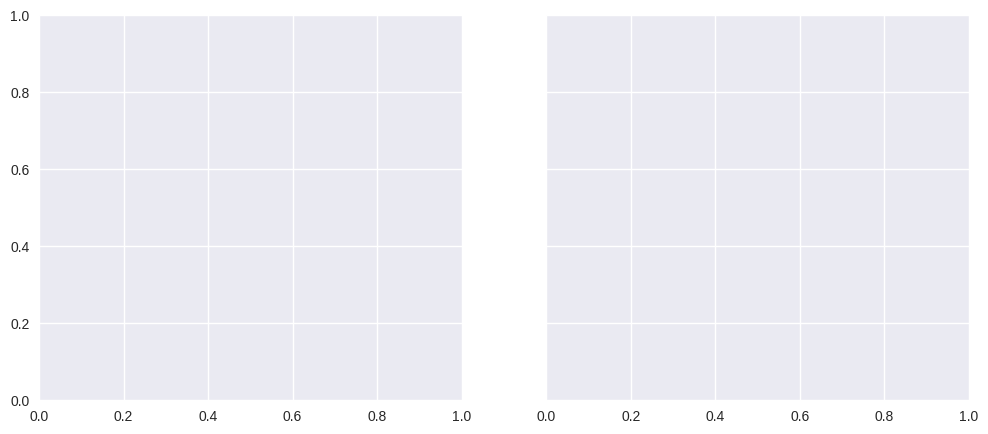

In [8]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(2 * 6, 1 * 5), sharey=True)
bins = np.linspace(-1, 1, 501)

[(r_hist, r_bins), (g_hist, g_bins)] = large_histogram(QSOs, 'name', 'mag', bins)
plot_numpy_histogram(axs[0], r_hist, r_bins, alpha=0.5, color='red', label='$r$ Distribution for QSO Types')
plot_numpy_histogram(axs[0], g_hist, g_bins, alpha=0.5, color='green', label='$g$ Distribution for QSO Types')

[(r_hist, r_bins), (g_hist, g_bins)] = large_histogram(nonQSOs, 'name', 'mag', bins)
plot_numpy_histogram(axs[1], r_hist, r_bins, alpha=0.5, color='red', label='$r$ Distribution for non-QSO Types')
plot_numpy_histogram(axs[1], g_hist, g_bins, alpha=0.5, color='green', label='$g$ Distribution for non-QSO Types')

for ax in axs.flatten():
    ax.legend(fontsize=10, loc='upper left')
    ax.tick_params(axis='both', which='both', labelsize=12)

fig.supxlabel(f'$dm$ {bins.size - 1} bins [magnitude]', size=16)
fig.supylabel('Normalised Counts', size=18, x=0.001)
fig.suptitle('$dm$ Distribution Lightcurves by Object', size=18)

plt.tight_layout()
plt.show()

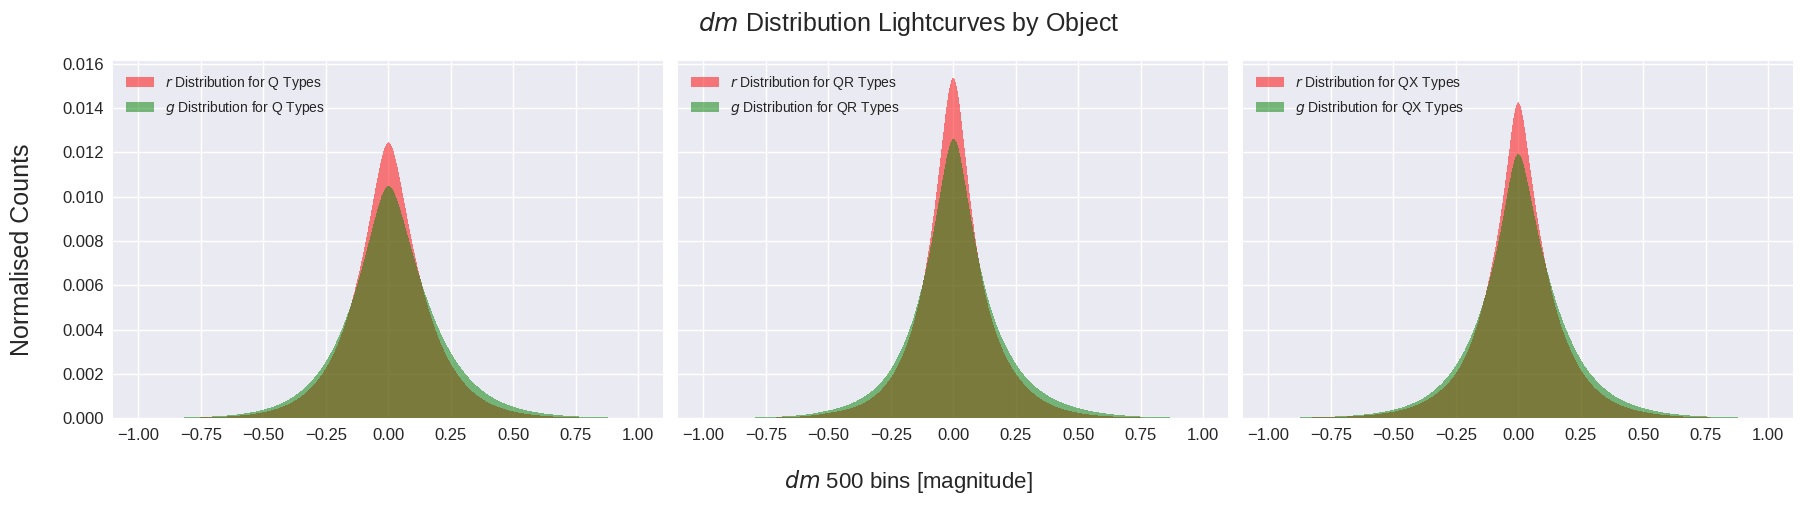

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(3 * 6, 1 * 5), sharey=True)
bins = np.linspace(-1, 1, 501)

[(r_hist, r_bins), (g_hist, g_bins)] = large_histogram(Qs, 'name', 'mag', bins)
plot_numpy_histogram(axs[0], r_hist, r_bins, label='$r$ Distribution for Q Types', density=True, alpha=0.5, color='red')
plot_numpy_histogram(axs[0], g_hist, g_bins, label='$g$ Distribution for Q Types', density=True, alpha=0.5, color='green')

[(r_hist, r_bins), (g_hist, g_bins)] = large_histogram(QRs, 'name', 'mag', bins)
plot_numpy_histogram(axs[1], r_hist, r_bins, label='$r$ Distribution for QR Types', density=True, alpha=0.5, color='red')
plot_numpy_histogram(axs[1], g_hist, g_bins, label='$g$ Distribution for QR Types', density=True, alpha=0.5, color='green')

[(r_hist, r_bins), (g_hist, g_bins)] = large_histogram(QXs, 'name', 'mag', bins)
plot_numpy_histogram(axs[2], r_hist, r_bins, label='$r$ Distribution for QX Types', density=True, alpha=0.5, color='red')
plot_numpy_histogram(axs[2], g_hist, g_bins, label='$g$ Distribution for QX Types', density=True, alpha=0.5, color='green')

for ax in axs.flatten():
    ax.legend(fontsize=10, loc='upper left')
    ax.tick_params(axis='both', which='both', labelsize=12)

fig.supxlabel(f'$dm$ {bins.size - 1} bins [magnitude]', size=16)
fig.supylabel('Normalised Counts', size=18, x=0.001)
fig.suptitle('$dm$ Distribution Lightcurves by Object', size=18)

plt.tight_layout()
plt.show()

## $dt$ distribution

### For the range 0 - 2000 days

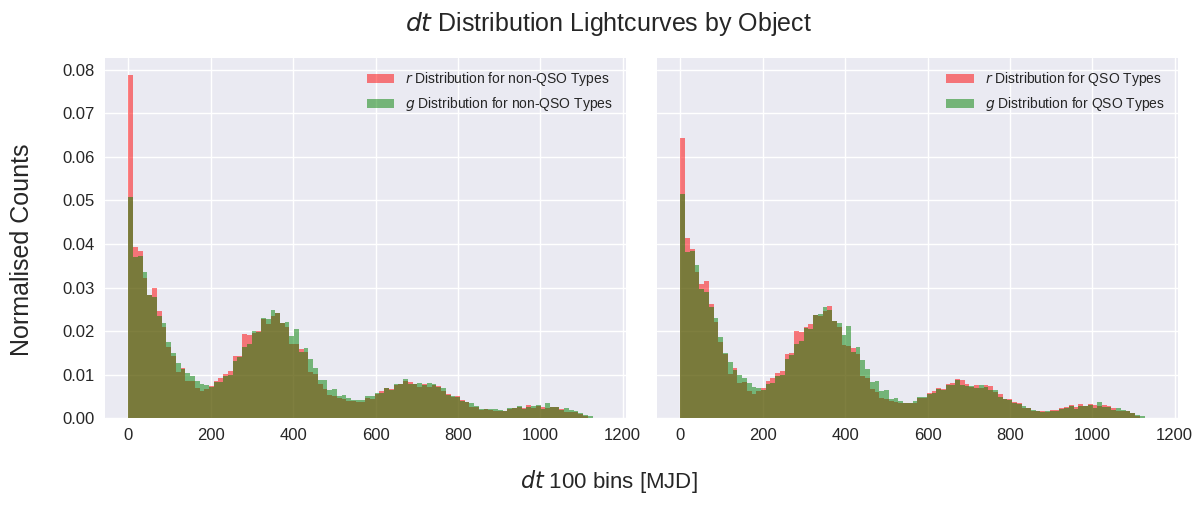

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(2 * 6, 1 * 5), sharey=True)
bins = np.linspace(0, 1150, 101)

[(r_hist, r_bins), (g_hist, g_bins)] = large_histogram(nonQSOs, 'name', 'time', bins)
plot_numpy_histogram(axs[0], r_hist, r_bins, label='$r$ Distribution for non-QSO Types', density=True, alpha=0.5, color='red')
plot_numpy_histogram(axs[0], g_hist, g_bins, label='$g$ Distribution for non-QSO Types', density=True, alpha=0.5, color='green')

[(r_hist, r_bins), (g_hist, g_bins)] = large_histogram(QSOs, 'name', 'time', bins)
plot_numpy_histogram(axs[1], r_hist, r_bins, label='$r$ Distribution for QSO Types', density=True, alpha=0.5, color='red')
plot_numpy_histogram(axs[1], g_hist, g_bins, label='$g$ Distribution for QSO Types', density=True, alpha=0.5, color='green')

for ax in axs.flatten():
    ax.legend(fontsize=10, loc='upper right')
    ax.tick_params(axis='both', which='both', labelsize=12)
    # ax.set_yscale("log")

fig.supxlabel(f'$dt$ {bins.size - 1} bins [MJD]', size=16)
fig.supylabel('Normalised Counts', size=18, x=0.001)
fig.suptitle('$dt$ Distribution Lightcurves by Object', size=18)

plt.tight_layout()
plt.show()

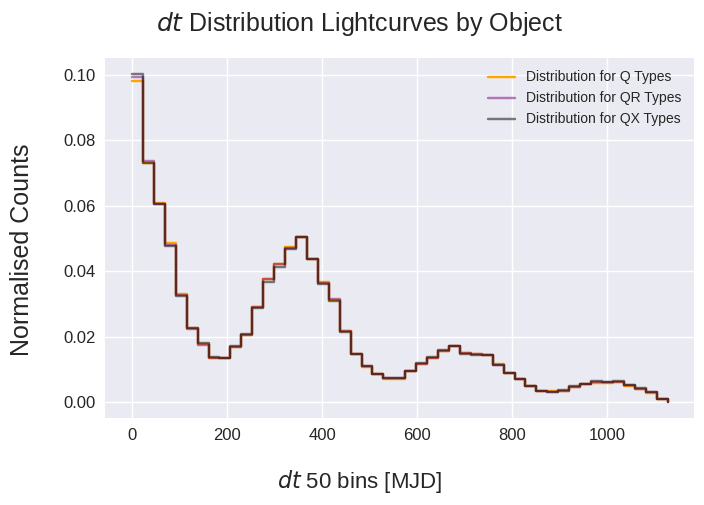

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(1 * 7, 1 * 5), sharey=True)
bins = np.linspace(0, 1150, 51)

[(r_hist, r_bins), (g_hist, g_bins)] = large_histogram(Qs, 'name', 'time', bins)
plot_numpy_step(ax, (r_hist + g_hist) / 2, r_bins, label='Distribution for Q Types', density=True, alpha=1, color='orange')

[(r_hist, r_bins), (g_hist, g_bins)] = large_histogram(QRs, 'name', 'time', bins)
plot_numpy_step(ax, (r_hist + g_hist) / 2, r_bins, label='Distribution for QR Types', density=True, alpha=0.5, color='purple')

[(r_hist, r_bins), (g_hist, g_bins)] = large_histogram(QXs, 'name', 'time', bins)
plot_numpy_step(ax, (r_hist + g_hist) / 2, r_bins, label='Distribution for QX Types', density=True, alpha=0.5, color='black')

# ax.set_yscale("log")
ax.tick_params(axis='both', which='both', labelsize=12)
ax.legend(fontsize=10, loc='upper right')

fig.supxlabel(f'$dt$ {bins.size - 1} bins [MJD]', size=16)
fig.supylabel('Normalised Counts', size=18, x=0.001)
fig.suptitle('$dt$ Distribution Lightcurves by Object', size=18)

plt.tight_layout()
plt.show()

### 0 - 2 days

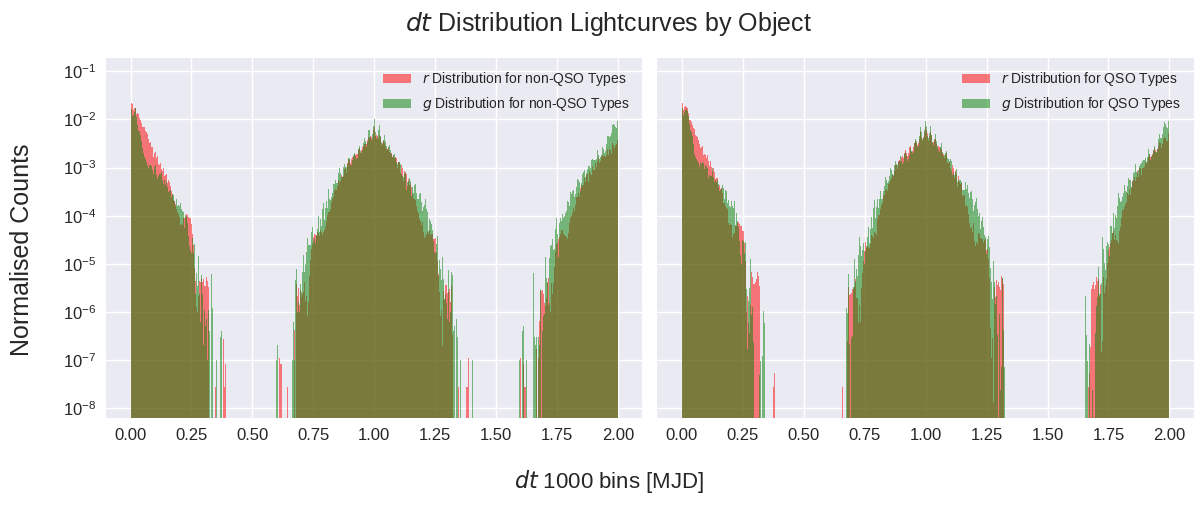

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(2 * 6, 1 * 5), sharey=True)
bins = np.linspace(0, 2, 1001)

[(r_hist, r_bins), (g_hist, g_bins)] = large_histogram(nonQSOs, 'name', 'time', bins)
plot_numpy_histogram(axs[0], r_hist, r_bins, label='$r$ Distribution for non-QSO Types', density=True, alpha=0.5, color='red')
plot_numpy_histogram(axs[0], g_hist, g_bins, label='$g$ Distribution for non-QSO Types', density=True, alpha=0.5, color='green')

[(r_hist, r_bins), (g_hist, g_bins)] = large_histogram(QSOs, 'name', 'time', bins)
plot_numpy_histogram(axs[1], r_hist, r_bins, label='$r$ Distribution for QSO Types', density=True, alpha=0.5, color='red')
plot_numpy_histogram(axs[1], g_hist, g_bins, label='$g$ Distribution for QSO Types', density=True, alpha=0.5, color='green')

for ax in axs.flatten():
    ax.legend(fontsize=10, loc='upper right')
    ax.tick_params(axis='both', which='both', labelsize=12)
    ax.set_yscale("log")

fig.supxlabel(f'$dt$ {bins.size - 1} bins [MJD]', size=16)
fig.supylabel('Normalised Counts', size=18, x=0.001)
fig.suptitle('$dt$ Distribution Lightcurves by Object', size=18)

plt.tight_layout()
plt.show()

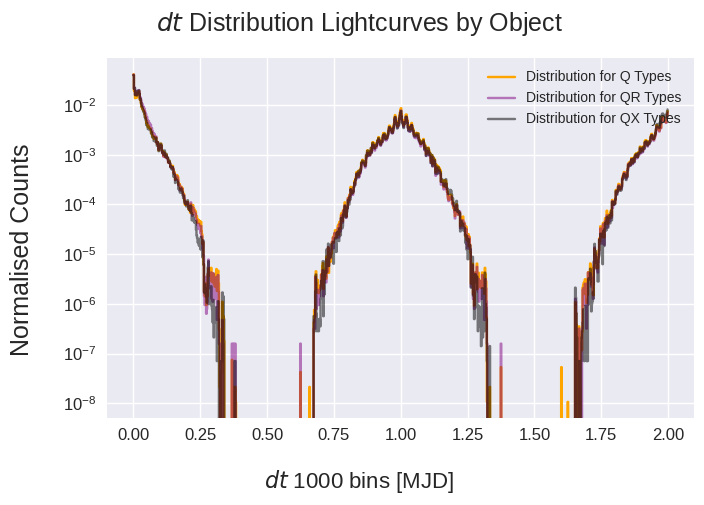

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(1 * 7, 1 * 5), sharey=True)
bins = np.linspace(0, 2, 1001)

[(r_hist, r_bins), (g_hist, g_bins)] = large_histogram(Qs, 'name', 'time', bins)
plot_numpy_step(ax, (r_hist + g_hist) / 2, r_bins, label='Distribution for Q Types', density=True, alpha=1, color='orange')

[(r_hist, r_bins), (g_hist, g_bins)] = large_histogram(QRs, 'name', 'time', bins)
plot_numpy_step(ax, (r_hist + g_hist) / 2, r_bins, label='Distribution for QR Types', density=True, alpha=0.5, color='purple')

[(r_hist, r_bins), (g_hist, g_bins)] = large_histogram(QXs, 'name', 'time', bins)
plot_numpy_step(ax, (r_hist + g_hist) / 2, r_bins, label='Distribution for QX Types', density=True, alpha=0.5, color='black')

ax.set_yscale("log")
ax.tick_params(axis='both', which='both', labelsize=12)
ax.legend(fontsize=10, loc='upper right')

fig.supxlabel(f'$dt$ {bins.size - 1} bins [MJD]', size=16)
fig.supylabel('Normalised Counts', size=18, x=0.001)
fig.suptitle('$dt$ Distribution Lightcurves by Object', size=18)

plt.tight_layout()
plt.show()

### 0 - 1 Hour

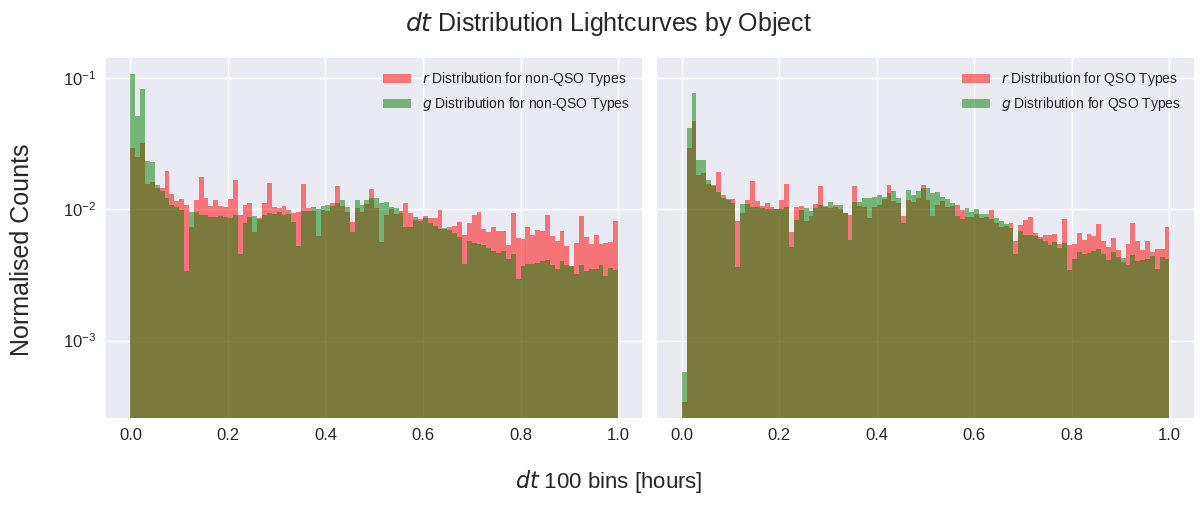

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(2 * 6, 1 * 5), sharey=True)
bins = np.linspace(0, 1 / 24, 101)

[(r_hist, r_bins), (g_hist, g_bins)] = large_histogram(nonQSOs, 'name', 'time', bins)
plot_numpy_histogram(axs[0], r_hist, r_bins * 24, label='$r$ Distribution for non-QSO Types', density=True, alpha=0.5, color='red')
plot_numpy_histogram(axs[0], g_hist, g_bins * 24, label='$g$ Distribution for non-QSO Types', density=True, alpha=0.5, color='green')

[(r_hist, r_bins), (g_hist, g_bins)] = large_histogram(QSOs, 'name', 'time', bins)
plot_numpy_histogram(axs[1], r_hist, r_bins * 24, label='$r$ Distribution for QSO Types', density=True, alpha=0.5, color='red')
plot_numpy_histogram(axs[1], g_hist, g_bins * 24, label='$g$ Distribution for QSO Types', density=True, alpha=0.5, color='green')

for ax in axs.flatten():
    ax.legend(fontsize=10, loc='upper right')
    ax.tick_params(axis='both', which='both', labelsize=12)
    ax.set_yscale("log")

fig.supxlabel(f'$dt$ {bins.size - 1} bins [hours]', size=16)
fig.supylabel('Normalised Counts', size=18, x=0.001)
fig.suptitle('$dt$ Distribution Lightcurves by Object', size=18)

plt.tight_layout()
plt.show()

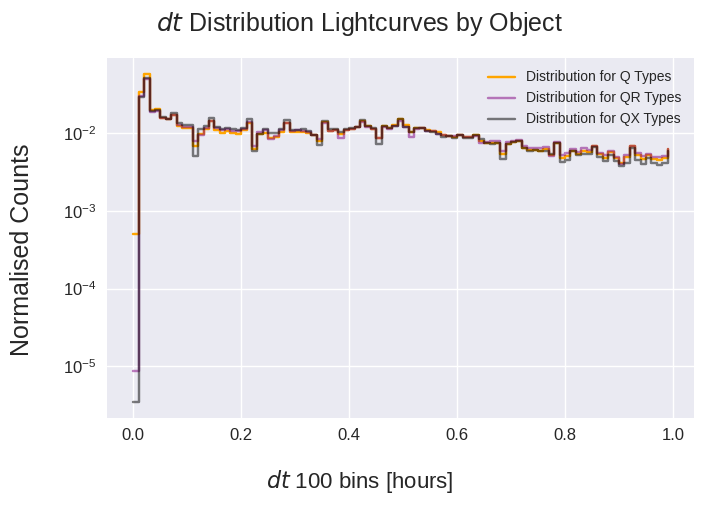

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(1 * 7, 1 * 5), sharey=True)
bins = np.linspace(0, 1 / 24, 101)

[(r_hist, r_bins), (g_hist, g_bins)] = large_histogram(Qs, 'name', 'time', bins)
plot_numpy_step(ax, (r_hist + g_hist) / 2, r_bins * 24, label='Distribution for Q Types', density=True, alpha=1, color='orange')

[(r_hist, r_bins), (g_hist, g_bins)] = large_histogram(QRs, 'name', 'time', bins)
plot_numpy_step(ax, (r_hist + g_hist) / 2, r_bins * 24, label='Distribution for QR Types', density=True, alpha=0.5, color='purple')

[(r_hist, r_bins), (g_hist, g_bins)] = large_histogram(QXs, 'name', 'time', bins)
plot_numpy_step(ax, (r_hist + g_hist) / 2, r_bins * 24, label='Distribution for QX Types', density=True, alpha=0.5, color='black')

ax.set_yscale("log")
ax.tick_params(axis='both', which='both', labelsize=12)
ax.legend(fontsize=10, loc='upper right')

fig.supxlabel(f'$dt$ {bins.size - 1} bins [hours]', size=16)
fig.supylabel('Normalised Counts', size=18, x=0.001)
fig.suptitle('$dt$ Distribution Lightcurves by Object', size=18)

plt.tight_layout()
plt.show()

### 0 - 2 Minutes

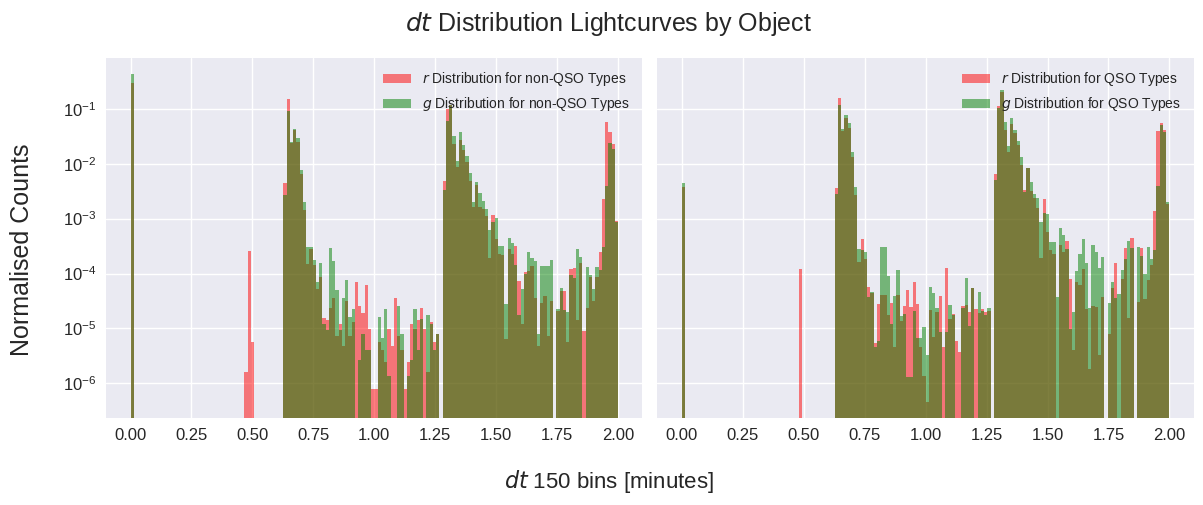

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(2 * 6, 1 * 5), sharey=True)
bins = np.linspace(0, 2 / (24 * 60), 151)

[(r_hist, r_bins), (g_hist, g_bins)] = large_histogram(nonQSOs, 'name', 'time', bins)
plot_numpy_histogram(axs[0], r_hist, r_bins * 24 * 60, label='$r$ Distribution for non-QSO Types', density=True, alpha=0.5, color='red')
plot_numpy_histogram(axs[0], g_hist, g_bins * 24 * 60, label='$g$ Distribution for non-QSO Types', density=True, alpha=0.5, color='green')

[(r_hist, r_bins), (g_hist, g_bins)] = large_histogram(QSOs, 'name', 'time', bins)
plot_numpy_histogram(axs[1], r_hist, r_bins * 24 * 60, label='$r$ Distribution for QSO Types', density=True, alpha=0.5, color='red')
plot_numpy_histogram(axs[1], g_hist, g_bins * 24 * 60, label='$g$ Distribution for QSO Types', density=True, alpha=0.5, color='green')

for ax in axs.flatten():
    ax.legend(fontsize=10, loc='upper right')
    ax.tick_params(axis='both', which='both', labelsize=12)
    ax.set_yscale("log")

fig.supxlabel(f'$dt$ {bins.size - 1} bins [minutes]', size=16)
fig.supylabel('Normalised Counts', size=18, x=0.001)
fig.suptitle('$dt$ Distribution Lightcurves by Object', size=18)

plt.tight_layout()
plt.show()

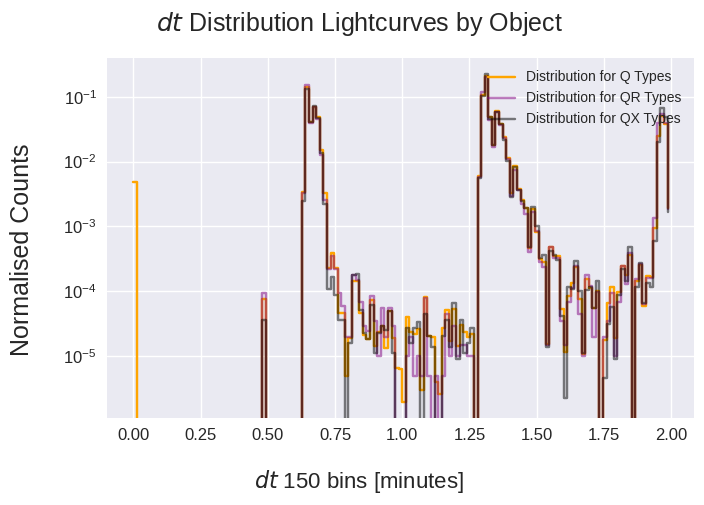

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(1 * 7, 1 * 5), sharey=True)
bins = np.linspace(0, 2 / (24 * 60), 151)

[(r_hist, r_bins), (g_hist, g_bins)] = large_histogram(Qs, 'name', 'time', bins)
plot_numpy_step(ax, (r_hist + g_hist) / 2, r_bins * 24 * 60, label='Distribution for Q Types', density=True, alpha=1, color='orange')

[(r_hist, r_bins), (g_hist, g_bins)] = large_histogram(QRs, 'name', 'time', bins)
plot_numpy_step(ax, (r_hist + g_hist) / 2, r_bins * 24 * 60, label='Distribution for QR Types', density=True, alpha=0.5, color='purple')

[(r_hist, r_bins), (g_hist, g_bins)] = large_histogram(QXs, 'name', 'time', bins)
plot_numpy_step(ax, (r_hist + g_hist) / 2, r_bins * 24 * 60, label='Distribution for QX Types', density=True, alpha=0.5, color='black')

ax.set_yscale("log")
ax.tick_params(axis='both', which='both', labelsize=12)
ax.legend(fontsize=10, loc='upper right')

fig.supxlabel(f'$dt$ {bins.size - 1} bins [minutes]', size=16)
fig.supylabel('Normalised Counts', size=18, x=0.001)
fig.suptitle('$dt$ Distribution Lightcurves by Object', size=18)

plt.tight_layout()
plt.show()

We have a couple of dt points at $dt = 0$ as well! That's somehting we need to watch out for. Will this happen even if we consider lightcurves by OID?